<a href="https://colab.research.google.com/github/Agnes-FD/Agnes-FD/blob/main/modelv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.image as mpimg
import os

In [2]:
%matplotlib inline

In [3]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.datasets import cifar10
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from IPython.display import Image, display
import random, os

In [4]:
#Make sure you're using GPU
!nvidia-smi

Tue Jun  1 11:08:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [6]:
cd '/content/drive/MyDrive/data'

/content/drive/MyDrive/data


In [7]:
path = '/content/drive/MyDrive/data'
# Membuat Label pada gambar berdasarkan klasifikasi
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(path):
  for name in files:
    full_path.append(os.path.join(path, name))
    tag.append(path.split('/')[-1])
    file_name.append(name)

In [8]:
# Membuat dataframe berdasarkan hasil klasifikasi data yang sudah diberi label

df = pd.DataFrame({"path":full_path, "file_name": file_name, "tag":tag})
df.groupby(['tag']).size()

tag
with_mask       3725
without_mask    3828
dtype: int64

In [11]:
# Membagi dataset menjadi dua bagian (train dan test)
from sklearn.model_selection import train_test_split

x = df['path']
y = df['tag']

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size= 0.20, random_state=300)

In [13]:
# menyatukan kedalam masing-masing dataframe
df_test = pd.DataFrame({
    'path' : x_test,
    'tag' : y_test,
    'set' : 'test'
})

df_train = pd.DataFrame({
    'path' : x_train,
    'tag' : y_train,
    'set' : 'train'
})

In [14]:
print('train size', len(df_train))
print('test size', len(df_test))

train size 6042
test size 1511


In [16]:
# melihat masing-masing dataset apakah sudah sesuai atau belum
df_all = df_train.append([df_test]).reset_index(drop=1)

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(4)


set    tag         
test   with_mask        739
       without_mask     772
train  with_mask       2986
       without_mask    3056
dtype: int64 




,path,tag,set
2772,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask,train
2233,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask,train
7550,/content/drive/MyDrive/data/without_mask/witho...,without_mask,test
5159,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask,train


In [17]:
# Memindahkan dataset
import shutil
from tqdm.notebook import tqdm as tq

datasource_path = '/content/drive/MyDrive/data'
dataset_path = '/content/drive/MyDrive/dataset'

for index, row in tq(df_all.iterrows()):
  file_path = row['path']

  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['tag'], row['image'].split('.')[0])

  if os.path.exists(os.path.join(dataset_path, row['set'], row['tag'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['tag']))
  
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['tag'], destination_file_name)

  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

In [18]:
# Define Directory
base_dir = '/content/drive/MyDrive/dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [19]:
os.listdir(train_dir)

['with_mask', 'without_mask']

In [20]:
os.listdir(test_dir)

['with_mask', 'without_mask']

In [22]:
!ls '/content/drive/MyDrive/dataset/test/'

with_mask  without_mask


In [24]:
test_imgs_count = sum([len(files) for r, d, files in os.walk("/content/drive/MyDrive/dataset/test/")])
test_imgs_count

1511

In [26]:
train_imgs_count = sum([len(files) for r, d, files in os.walk("/content/drive/MyDrive/dataset/train/")])
train_imgs_count

6042

In [27]:
batch_size_train = 71
batch_size_test = 1

In [48]:
def display20randomimages(t):
  fig=plt.figure(figsize=(8, 8))
  columns = 4
  rows = 5
  for i in range(1, columns*rows +1):
    c = "/" + str(random.choice(['with_mask/', 'without_mask/'])) + "/"
    random_filename = random.choice([
        x for x in os.listdir(t + c)
        if os.path.isfile(os.path.join(t+c, x))
    ])
    img = mpimg.imread(t+c+random_filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
  plt.show()

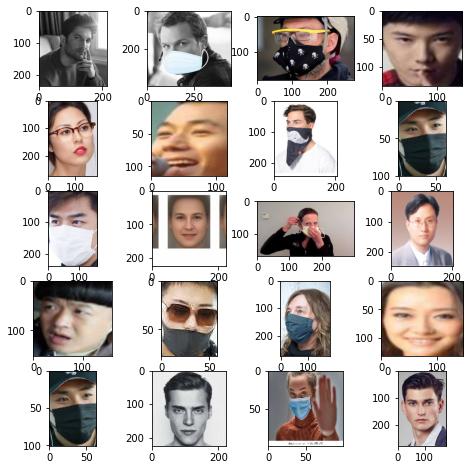

In [49]:
display20randomimages('/content/drive/MyDrive/dataset/train')

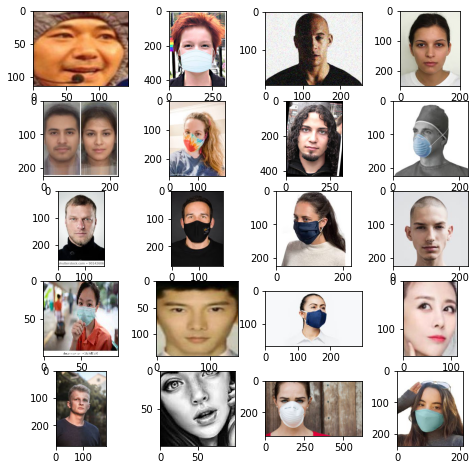

In [50]:
display20randomimages('/content/drive/MyDrive/dataset/test')

In [54]:
train_datagen = ImageDataGenerator(
        rescale=1./255)
#consider adding horizontal flip = true here

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/dataset/train",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size_train,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/dataset/train",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)
optimizer = Adam(learning_rate=0.0001)

Found 6042 images belonging to 2 classes.
Found 6042 images belonging to 2 classes.


In [65]:
inp = Input(shape = (224,224,3))

x = Conv2D(32, (5,5), strides=(1, 1), padding='same', activation='relu', use_bias=True)(inp)
x = Conv2D(32, (3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same', data_format=None)(x)
x = Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(x)
x = Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same', data_format=None)(x)
x = Conv2D(128, (3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(x)
x = Conv2D(128, (3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same', data_format=None)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model_scratch = Model(inputs=inp, outputs= x)

model_scratch.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
model_scratch.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=10
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
13/85 [===>..........................] - ETA: 17s - loss: 0.6974 - accuracy: 0.5673

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


85/85 [==============================] - 26s 271ms/step - loss: 0.5444 - accuracy: 0.7266
Epoch 2/10
85/85 [==============================] - 23s 273ms/step - loss: 0.2615 - accuracy: 0.8894
Epoch 3/10
85/85 [==============================] - 23s 272ms/step - loss: 0.2112 - accuracy: 0.9153
Epoch 4/10
85/85 [==============================] - 23s 272ms/step - loss: 0.1839 - accuracy: 0.9276
Epoch 5/10
85/85 [==============================] - 23s 275ms/step - loss: 0.1676 - accuracy: 0.9361
Epoch 6/10
85/85 [==============================] - 23s 271ms/step - loss: 0.1176 - accuracy: 0.9562
Epoch 7/10
85/85 [==============================] - 23s 270ms/step - loss: 0.0967 - accuracy: 0.9654
Epoch 8/10
85/85 [==============================] - 23s 267ms/step - loss: 0.0722 - accuracy: 0.9763
Epoch 9/10
85/85 [==============================] - 23s 273ms/step - loss: 0.0563 - accuracy: 0.9808
Epoch 10/10
85/85 [==============================] - 23s 273ms/step - loss: 0.0317 - accuracy: 0.9907


In [66]:

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image

model_mobile = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
x1 = model_mobile(inp)
x2 = GlobalAveragePooling2D()(x1)
out = Dense(2, activation='softmax')(x2)

model_mobile = Model(inputs = inp, outputs = out)
model_mobile.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
model_mobile.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=10
)

9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
84/85 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9290

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


85/85 [==============================] - 44s 366ms/step - loss: 0.1453 - accuracy: 0.9301
Epoch 2/10
85/85 [==============================] - 32s 364ms/step - loss: 0.0080 - accuracy: 0.9960
Epoch 3/10
85/85 [==============================] - 31s 366ms/step - loss: 0.0086 - accuracy: 0.9982
Epoch 4/10
85/85 [==============================] - 31s 363ms/step - loss: 8.3256e-04 - accuracy: 1.0000
Epoch 5/10
85/85 [==============================] - 31s 368ms/step - loss: 1.7428e-04 - accuracy: 1.0000
Epoch 6/10
85/85 [==============================] - 31s 365ms/step - loss: 1.7549e-04 - accuracy: 1.0000
Epoch 7/10
85/85 [==============================] - 31s 365ms/step - loss: 5.8598e-05 - accuracy: 1.0000
Epoch 8/10
85/85 [==============================] - 31s 364ms/step - loss: 1.6182e-04 - accuracy: 1.0000
Epoch 9/10
85/85 [==============================] - 31s 366ms/step - loss: 2.0308e-04 - accuracy: 1.0000
Epoch 10/10
85/85 [==============================] - 31s 366ms/step - loss: 5.

In [67]:
#train accuracy
train_generator.reset()
model_scratch.evaluate_generator(train_generator, steps=(train_imgs_count/batch_size_train))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[0.02845609188079834, 0.9922211170196533]

In [68]:
#test accuracy
test_generator.reset()
model_scratch.evaluate_generator(test_generator, steps=(test_imgs_count/batch_size_test))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.03859902173280716, 0.9907346367835999]

In [69]:
#train accuracy
train_generator.reset()
model_mobile.evaluate_generator(train_generator, steps=(train_imgs_count/batch_size_train))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[0.0009215195896103978, 0.9996689558029175]

In [70]:
#test accuracy
test_generator.reset()
model_mobile.evaluate_generator(test_generator, steps=(test_imgs_count/batch_size_test))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.0033679609186947346, 0.9986763596534729]